In [1]:
pip install rembg onnxruntime tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import random
import math
import time
from rembg import remove
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Loading Fruit360 data in the colab

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

100%|██████████| 3.47G/3.47G [00:38<00:00, 97.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/46


# Formatting data for SVM, KNN, and Random Forest

In [5]:
def process_train_dataset(base_path):
    """
    Process a dataset of fruit images, creating flattened pixel arrays and labels.
    Only the first 100 valid images from each folder are processed.

    Args:
        base_path (str): Path to the base directory containing fruit folders.

    Returns:
        list: List of [flattened_image_array, label] pairs.
    """
    # Lists to store processed data
    data = []

    # Supported image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # Iterate through each folder (representing a fruit type)
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if not os.path.isdir(folder_path):
            continue  # Skip non-folder files

        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
        image_files = image_files[:250]  # Take the first 100 images only

        for image_filename in image_files:
            image_path = os.path.join(folder_path, image_filename)

            try:
                with Image.open(image_path) as img:
                    # Resize to consistent size (60x60)
                    img_resized = img.resize((60, 60))

                    # Convert to RGB if not already
                    img_rgb = img_resized.convert('RGB')

                    # Flatten the image
                    img_array = np.array(img_rgb).flatten()

                    # Append image array and label (folder name)
                    data.append([img_array, folder_name])

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return data


In [6]:
def process_test_dataset(base_path):
    """
    Process a dataset of fruit images, creating flattened pixel arrays and labels.
    Only the first 100 valid images from each folder are processed.

    Args:
        base_path (str): Path to the base directory containing fruit folders.

    Returns:
        list: List of [flattened_image_array, label] pairs.
    """
    # Lists to store processed data
    data = []

    # Supported image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # Iterate through each folder (representing a fruit type)
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if not os.path.isdir(folder_path):
            continue  # Skip non-folder files

        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
        image_files = image_files[:100]  # Take the first 100 images only

        for image_filename in image_files:
            image_path = os.path.join(folder_path, image_filename)

            try:
                with Image.open(image_path) as img:
                    # Resize to consistent size (60x60)
                    img_resized = img.resize((60, 60))

                    # Convert to RGB if not already
                    img_rgb = img_resized.convert('RGB')

                    # Flatten the image
                    img_array = np.array(img_rgb).flatten()

                    # Append image array and label (folder name)
                    data.append([img_array, folder_name])

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return data

In [7]:
# Example usage
train_directory = '/content/gdrive/MyDrive/fruit_360/train'
train_data = process_train_dataset(train_directory)

In [8]:
test_directory = '/content/gdrive/MyDrive/fruit_360/test'
test_data = process_test_dataset(test_directory)

In [9]:
print(len(train_data))
print(len(test_data))

5750
2300


In [10]:
train_features = []
train_labels = []

random.shuffle(train_data)

for feature, label in train_data:
  train_features.append(feature)
  train_labels.append(label)

In [11]:
test_features = []
test_labels = []

random.shuffle(test_data)

for feature, label in test_data:
  test_features.append(feature)
  test_labels.append(label)

# Formatting data for ResNet

In [ ]:
# Load training dataset without any preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(100, 100),
    seed=123,
    shuffle=True,
)

# Load validation dataset without any preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(100, 100),
    seed=42,
)

Found 12431 files belonging to 23 classes.
Using 9945 files for training.
Found 12431 files belonging to 23 classes.
Using 2486 files for validation.


In [ ]:
# for faster training which takes less time and less memory for training

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Data Augmentation

# Augmentation for training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

# Background removal

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 197GB/s]


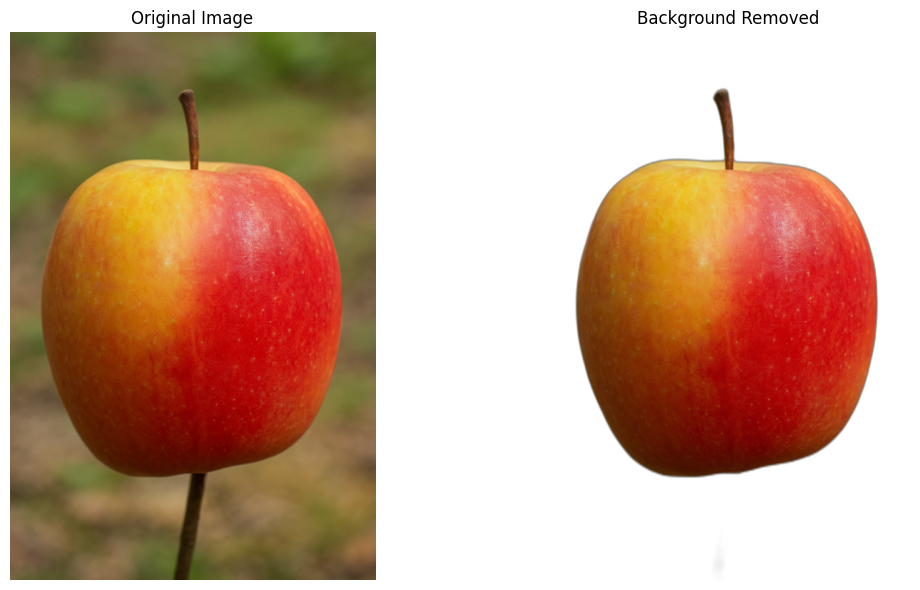

In [ ]:
# === 1. Load image from Google Drive ===
image_path = '/content/gdrive/MyDrive/fruit_360/pink_lady.png'  # Change this path
original_image = Image.open(image_path).convert("RGBA")

# === 2. Remove background ===
bg_removed_image = remove(original_image)

# === 3. Resize for display
original_resized = original_image.resize((original_image.width // 2, original_image.height // 2))
bg_removed_resized = bg_removed_image.resize((bg_removed_image.width // 2, bg_removed_image.height // 2))

# === 4. Display side-by-side ===
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_resized)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(bg_removed_resized)
plt.title("Background Removed")
plt.axis("off")

plt.tight_layout()
plt.show()

# SVM

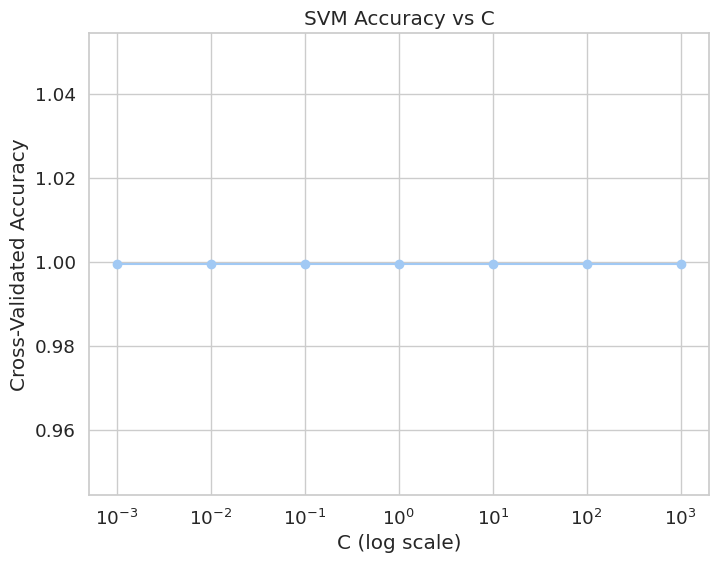

Best C: 0.001
Best cross-validated accuracy: 0.9994782608695651


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# Define range of C values (log scale)
C_values = np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Setup GridSearchCV
param_grid = {'C': C_values}
grid_search = GridSearchCV(SVC(kernel='linear', gamma='scale', random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit with training data
grid_search.fit(train_features, train_labels)

# Extract results
results = grid_search.cv_results_
mean_scores = results['mean_test_score']

# Plot Accuracy vs C
plt.figure(figsize=(8, 6))
plt.semilogx(C_values, mean_scores, marker='o')
plt.xlabel("C (log scale)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("SVM Accuracy vs C")
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/svm_tuning.png', bbox_inches='tight', dpi=300)
plt.show()

print("Best C:", grid_search.best_params_['C'])
print("Best cross-validated accuracy:", grid_search.best_score_)


In [28]:
# Creating the model

start_time_svm = time.time()
model_svm = SVC(C=1.0, kernel='linear', gamma='scale', random_state=42)
model_svm.fit(train_features, train_labels)
svm_train_time = time.time() - start_time_svm

In [29]:
y_pred = model_svm.predict(train_features)
print(metrics.accuracy_score(train_labels, y_pred))

1.0


In [30]:
y_pred_test = model_svm.predict(test_features)
svm_accuracy = metrics.accuracy_score(test_labels, y_pred_test)
print(svm_accuracy)

0.9860869565217392


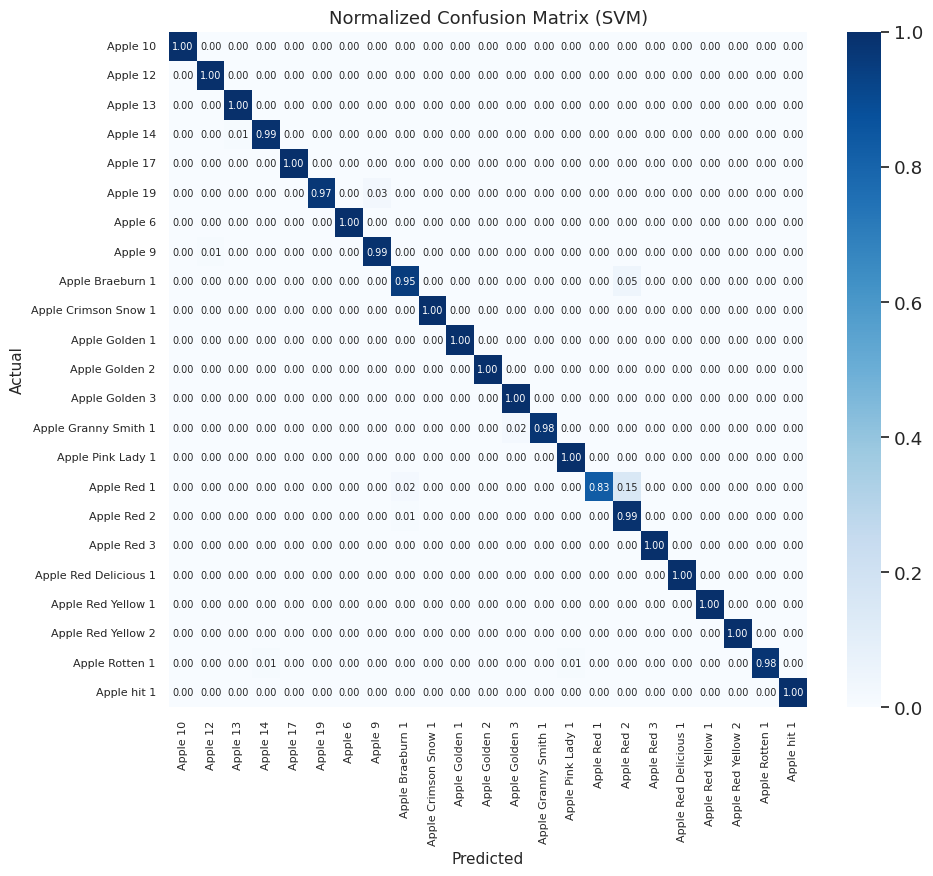

In [31]:
# Compute normalized confusion matrix
cm_svm = confusion_matrix(test_labels, y_pred_test, normalize='true')

plt.figure(figsize=(10, 9))
sns.heatmap(cm_svm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels),
            annot_kws={"size": 7})

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (SVM)", fontsize=13)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/confusion_matrix_svm.png', bbox_inches='tight', dpi=300)
plt.show()

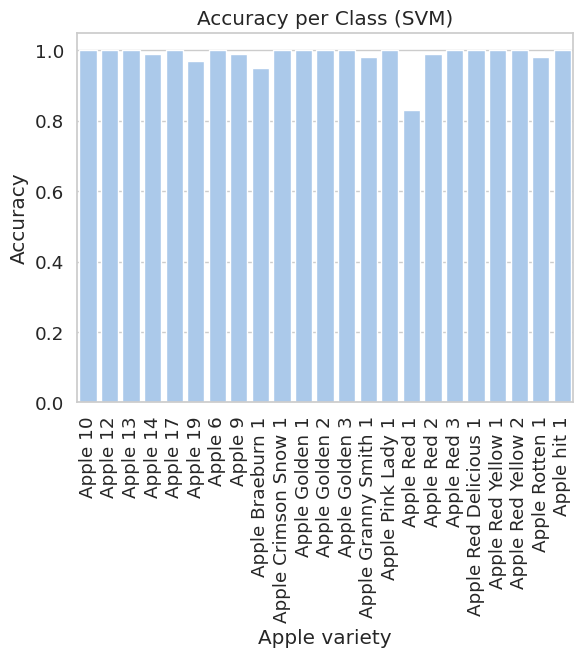

In [32]:
class_accuracies_svm = cm_svm.diagonal()
class_accuracies_svm

sns.barplot(x=np.unique(test_labels), y=class_accuracies_svm)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.xlabel('Apple variety')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class (SVM)')
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_svm.png', bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(test_labels, y_pred_test))

                       precision    recall  f1-score   support

             Apple 10       1.00      1.00      1.00       100
             Apple 12       0.99      1.00      1.00       100
             Apple 13       0.99      1.00      1.00       100
             Apple 14       0.99      0.99      0.99       100
             Apple 17       1.00      1.00      1.00       100
             Apple 19       1.00      0.97      0.98       100
              Apple 6       1.00      1.00      1.00       100
              Apple 9       0.97      0.99      0.98       100
     Apple Braeburn 1       0.97      0.95      0.96       100
 Apple Crimson Snow 1       1.00      1.00      1.00       100
       Apple Golden 1       1.00      1.00      1.00       100
       Apple Golden 2       1.00      1.00      1.00       100
       Apple Golden 3       0.98      1.00      0.99       100
 Apple Granny Smith 1       1.00      0.98      0.99       100
    Apple Pink Lady 1       0.99      1.00      1.00  

# KNN

In [13]:
# Creating the model

start_time_knn = time.time()
model_knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean', weights='uniform')
model_knn.fit(train_features, train_labels)
knn_train_time = time.time() - start_time_knn

In [14]:
y_pred_knn = model_knn.predict(train_features)
print(metrics.accuracy_score(train_labels, y_pred_knn))

0.9994782608695653


In [16]:
y_pred_knn_test = model_knn.predict(test_features)
knn_accuracy = metrics.accuracy_score(test_labels, y_pred_knn_test)
print(knn_accuracy)

0.9152173913043479


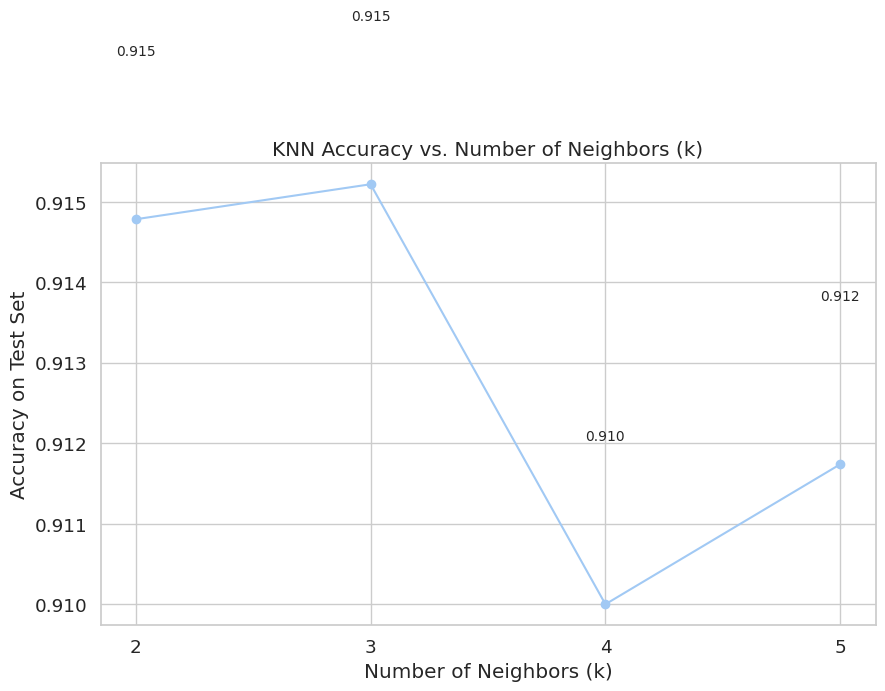

In [ ]:
# Define relevant k values for apple classification
k_values = list(range(2, 6, 1))  #32
accuracies = []

# Fit KNN for each k and record accuracy
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features, train_labels)
    y_pred = knn.predict(test_features)
    acc = accuracy_score(test_labels, y_pred)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy on Test Set')
plt.xticks(k_values)
plt.grid(True)

# Annotate each point with its accuracy value
for i, acc in enumerate(accuracies):
    plt.text(k_values[i], accuracies[i] + 0.002, f"{acc:.3f}", ha='center', va='bottom', fontsize=10)

plt.savefig('/content/gdrive/MyDrive/knn_accuracy_vs_k.png', bbox_inches='tight')
plt.show()

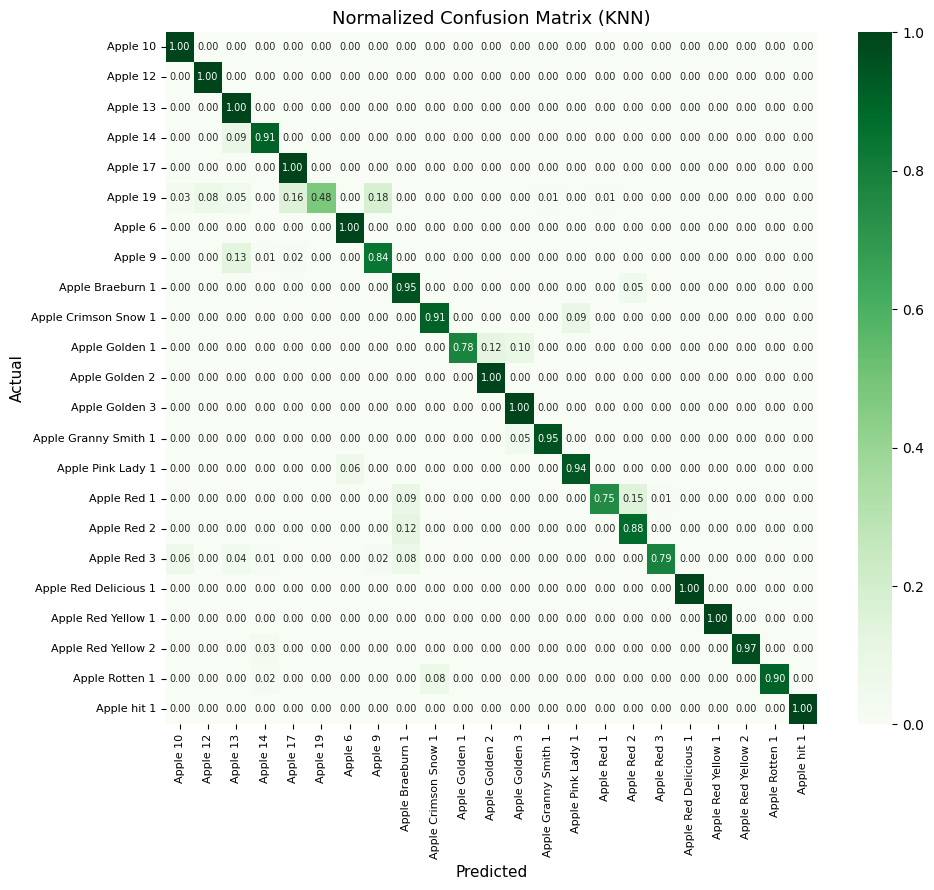

In [17]:
cm_knn = confusion_matrix(test_labels, y_pred_knn_test, normalize='true')

plt.figure(figsize=(10, 9))
sns.heatmap(cm_knn,
            annot=True,
            fmt=".2f",
            cmap="Greens",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels),
            annot_kws={"size": 7})

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (KNN)", fontsize=13)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/confusion_matrix_knn.png', bbox_inches='tight', dpi=300)
plt.show()


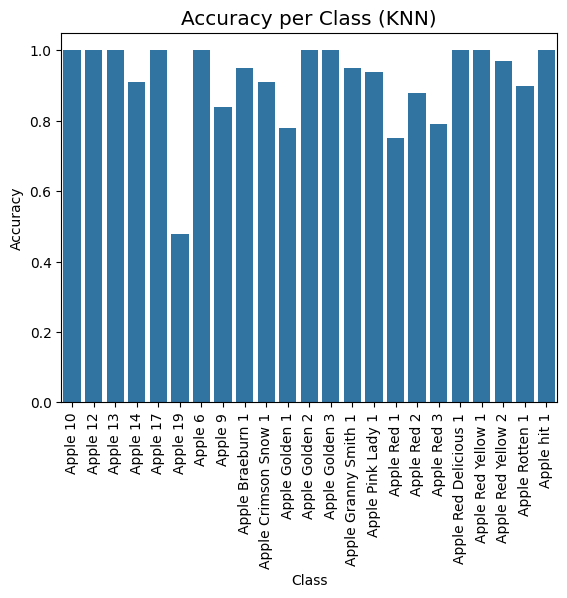

In [18]:
class_accuracies_knn = cm_knn.diagonal()

sns.barplot(x=np.unique(test_labels), y=class_accuracies_knn)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class (KNN)')
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_knn.png', bbox_inches='tight')
plt.show()

In [27]:
print(classification_report(test_labels, y_pred_knn_test))

                       precision    recall  f1-score   support

             Apple 10       0.92      1.00      0.96       100
             Apple 12       0.93      1.00      0.96       100
             Apple 13       0.76      1.00      0.87       100
             Apple 14       0.93      0.91      0.92       100
             Apple 17       0.85      1.00      0.92       100
             Apple 19       1.00      0.48      0.65       100
              Apple 6       0.94      1.00      0.97       100
              Apple 9       0.81      0.84      0.82       100
     Apple Braeburn 1       0.77      0.95      0.85       100
 Apple Crimson Snow 1       0.92      0.91      0.91       100
       Apple Golden 1       1.00      0.78      0.88       100
       Apple Golden 2       0.89      1.00      0.94       100
       Apple Golden 3       0.87      1.00      0.93       100
 Apple Granny Smith 1       0.99      0.95      0.97       100
    Apple Pink Lady 1       0.91      0.94      0.93  

# Random Forest

In [19]:
# Creating the model

start_time_rf = time.time()
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(train_features, train_labels)
rf_train_time = time.time() - start_time_rf

In [20]:
y_pred = model_rf.predict(train_features)
print(metrics.accuracy_score(train_labels, y_pred))

1.0


In [22]:
y_pred_test_rf = model_rf.predict(test_features)
rf_accuracy = metrics.accuracy_score(test_labels, y_pred_test_rf)
print(rf_accuracy)

0.9560869565217391


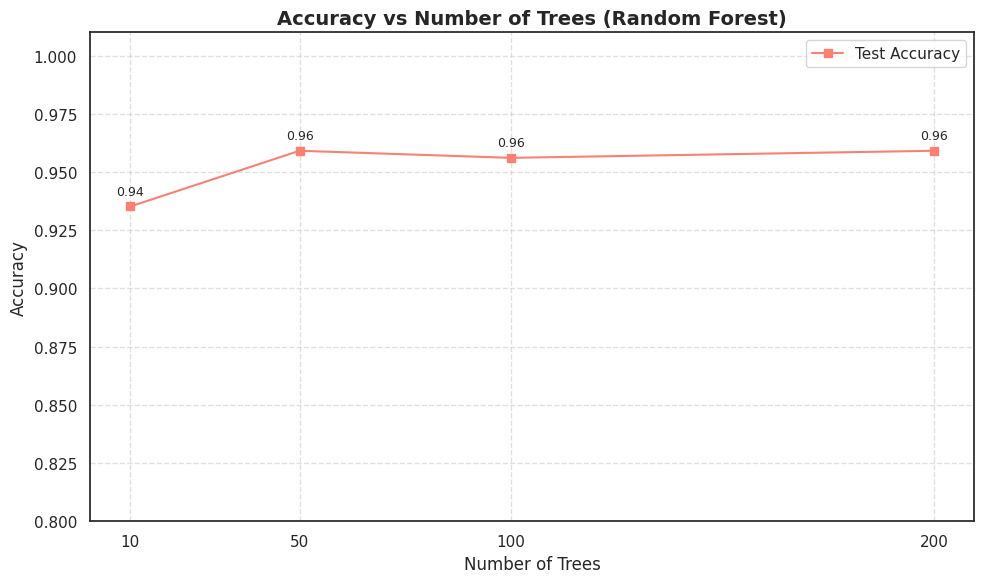

In [40]:
# ===========================================
# 🔹 4. Accuracy vs Number of Trees
# ===========================================
# Define hyperparameter values (number of trees)
estimators = [10, 50, 100, 200]
train_acc, test_acc = [], []

# Measure accuracy for each number of trees
for n in estimators:
    model = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    model.fit(train_features, train_labels)
    train_acc.append(accuracy_score(train_labels, model.predict(train_features)))
    test_acc.append(accuracy_score(test_labels, model.predict(test_features)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(estimators, test_acc, marker='s', linestyle='-', color='salmon', label='Test Accuracy')

# Add annotations
for i, (x, y) in enumerate(zip(estimators, test_acc)):
    plt.text(x, y + 0.005, f"{y:.2f}", ha='center', fontsize=9)

# Aesthetics
plt.title('Accuracy vs Number of Trees (Random Forest)', fontsize=14, weight='bold')
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.xticks(estimators)
plt.ylim(0.8, 1.01)  # adjust based on your data
plt.tight_layout()

# Save and show
plt.savefig('/content/gdrive/MyDrive/accuracy_vs_trees.png', bbox_inches='tight')
plt.show()
plt.close()


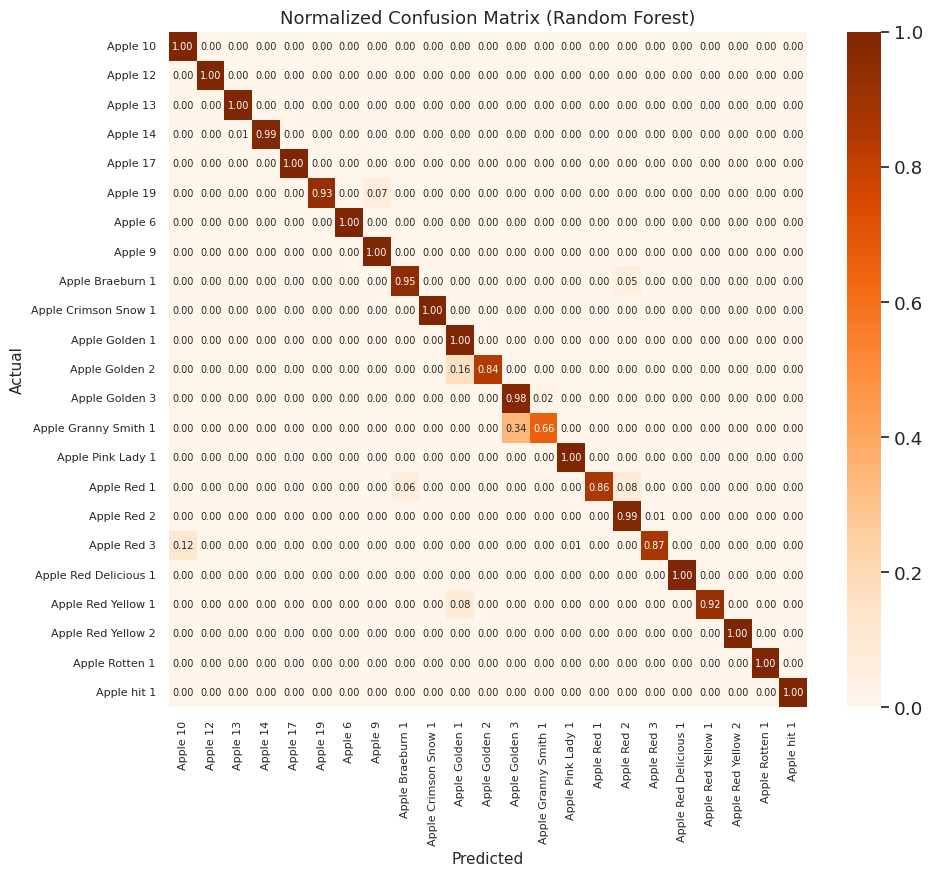

In [24]:
cm_rf = confusion_matrix(test_labels, y_pred_test_rf, normalize='true')  # Reuse y_pred_test from RF block

plt.figure(figsize=(10, 9))
sns.heatmap(cm_rf,
            annot=True,
            fmt=".2f",
            cmap="Oranges",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels),
            annot_kws={"size": 7})

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (Random Forest)", fontsize=13)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/confusion_matrix_rf.png', bbox_inches='tight', dpi=300)
plt.show()


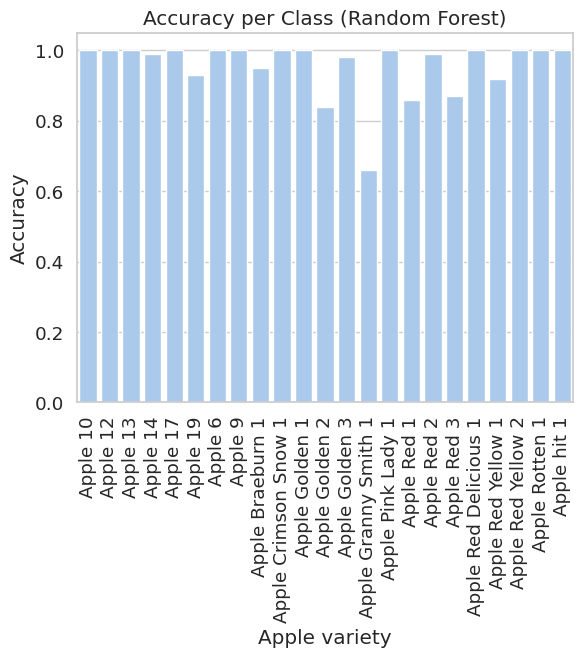

In [25]:
class_accuracies_rf = cm_rf.diagonal()

sns.barplot(x=np.unique(test_labels), y=class_accuracies_rf)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.xlabel('Apple variety')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class (Random Forest)')
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_rf.png', bbox_inches='tight')
plt.show()

In [26]:
print(classification_report(test_labels, y_pred_test_rf))

                       precision    recall  f1-score   support

             Apple 10       0.89      1.00      0.94       100
             Apple 12       1.00      1.00      1.00       100
             Apple 13       0.99      1.00      1.00       100
             Apple 14       1.00      0.99      0.99       100
             Apple 17       1.00      1.00      1.00       100
             Apple 19       1.00      0.93      0.96       100
              Apple 6       1.00      1.00      1.00       100
              Apple 9       0.93      1.00      0.97       100
     Apple Braeburn 1       0.94      0.95      0.95       100
 Apple Crimson Snow 1       1.00      1.00      1.00       100
       Apple Golden 1       0.81      1.00      0.89       100
       Apple Golden 2       1.00      0.84      0.91       100
       Apple Golden 3       0.74      0.98      0.84       100
 Apple Granny Smith 1       0.97      0.66      0.79       100
    Apple Pink Lady 1       0.99      1.00      1.00  

# ResNet

In [ ]:
# Get the class names from the subdirectories in the training directory
class_names = sorted(os.listdir(train_directory))

# Print the class names and the number of classes
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Apple 10', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 19', 'Apple 6', 'Apple 9', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1']
Number of Classes: 23


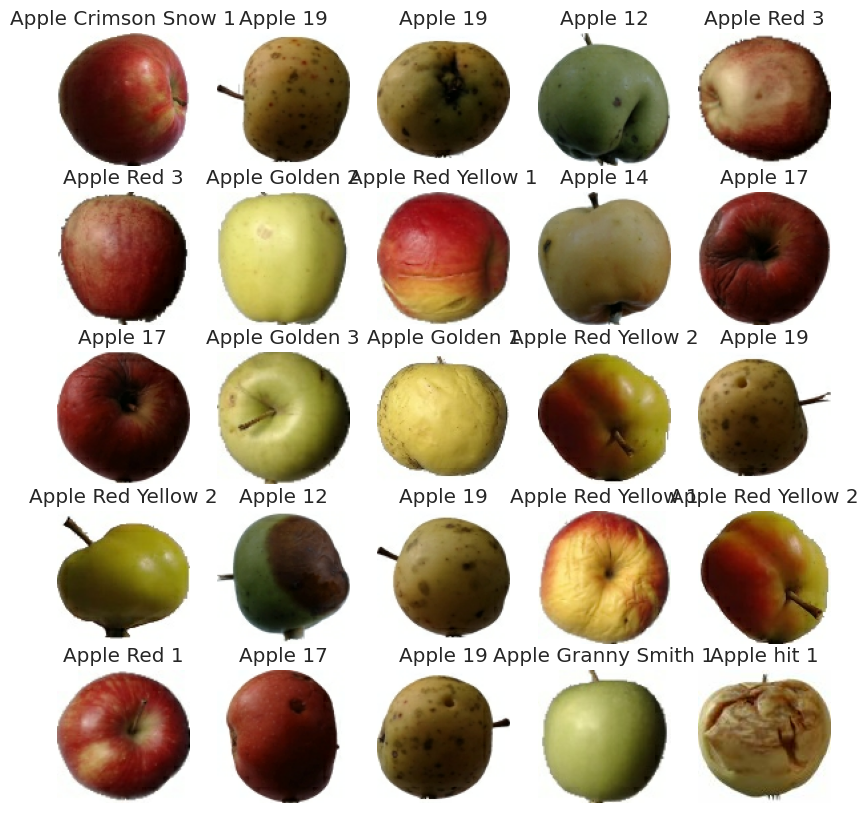

In [ ]:
# Function to display images from a dataset
def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(25):  # Display 25 images
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Show images from training dataset
show_images(train_ds, class_names)
plt.show()

In [ ]:
#ResNet 50 setup

# Using resNET model of transfer learning for training
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [ ]:
#Building the Model

inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Model training-

# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(patience=3)

start_time_resnet = time.time()

# Train the model with early stopping
history = resnet_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the training process
)

time_resnet = time.time() - start_time_resnet

Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.2138 - loss: 2.8777 - val_accuracy: 0.7908 - val_loss: 1.0320
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7296 - loss: 0.9658 - val_accuracy: 0.9014 - val_loss: 0.5378
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8602 - loss: 0.5452 - val_accuracy: 0.9570 - val_loss: 0.3425
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9205 - loss: 0.3561 - val_accuracy: 0.9787 - val_loss: 0.2440
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9439 - loss: 0.2745 - val_accuracy: 0.9855 - val_loss: 0.1852
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9625 - loss: 0.2087 - val_accuracy: 0.9879 - val_loss: 0.1566
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9697 - loss: 0.1680 - val_accuracy: 0.9924 - val_loss: 0.1221
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9791 - loss: 0.1365 - 

In [ ]:
resnet_accuracy = resnet_model.evaluate(val_ds)[1]  # Assuming accuracy is the second metric
print(f"ResNet Test Accuracy: {resnet_accuracy:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9962 - loss: 0.0775
ResNet Test Accuracy: 0.9956


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/ste

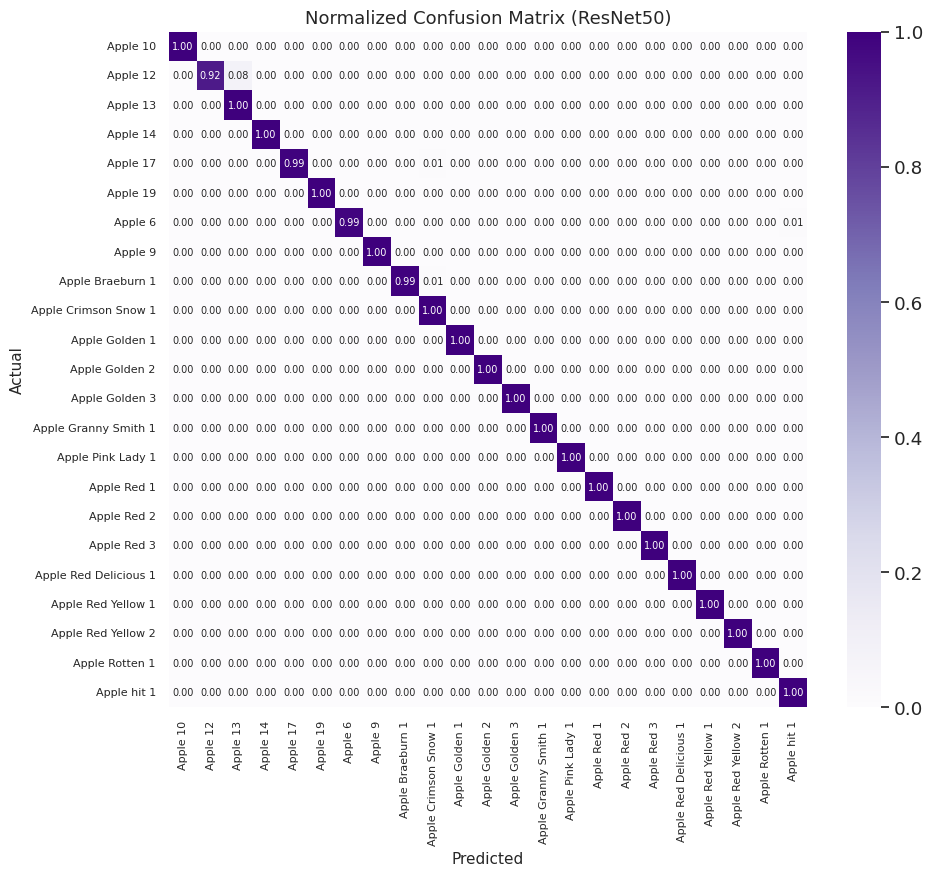

In [ ]:
# 1. Extract true and predicted labels from the validation dataset
resnet_true_labels = []
resnet_pred_labels = []

for batch_images, batch_labels in val_ds:
    predictions = resnet_model.predict(batch_images)
    predicted_classes = np.argmax(predictions, axis=1)

    resnet_true_labels.extend(batch_labels.numpy())
    resnet_pred_labels.extend(predicted_classes)

# 2. Compute normalized confusion matrix
cm_resnet = confusion_matrix(resnet_true_labels, resnet_pred_labels, normalize='true')

# 4. Plot the heatmap (smaller layout, consistent style)
plt.figure(figsize=(10, 9))
sns.heatmap(cm_resnet,
            annot=True,
            fmt=".2f",
            cmap="Purples",
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 7})

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (ResNet50)", fontsize=13)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/fruit_360/confusion_matrix_resnet_small.png', bbox_inches='tight', dpi=300)
plt.show()

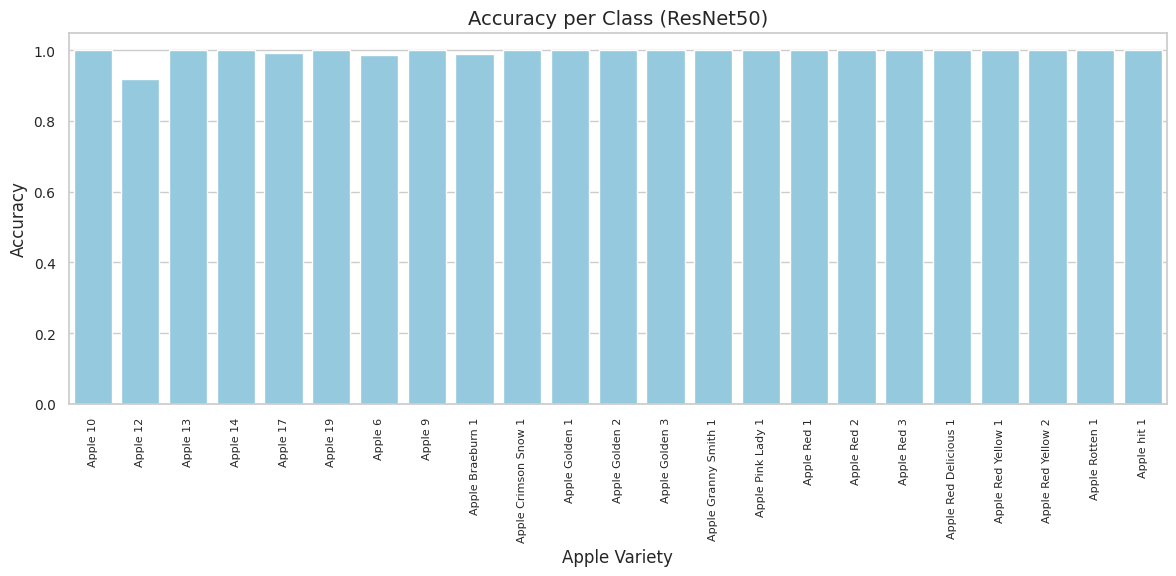

In [ ]:
# Convert to NumPy arrays if not already
resnet_true_labels = np.array(resnet_true_labels)
resnet_pred_labels = np.array(resnet_pred_labels)

# Compute class-wise accuracy
class_accuracies_resnet = []
for i in range(len(class_names)):
    true_class_indices = (resnet_true_labels == i)
    correct_predictions = (resnet_pred_labels[true_class_indices] == i).sum()
    total_samples = true_class_indices.sum()
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    class_accuracies_resnet.append(accuracy)

# Plot with a fixed color
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_accuracies_resnet, color="skyblue")  # Uniform color

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.xlabel("Apple Variety", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy per Class (ResNet50)", fontsize=14)
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_resnet.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# True and predicted labels already collected using this:
resnet_true_labels = []
resnet_pred_labels = []

for batch_images, batch_labels in val_ds:
    predictions = resnet_model.predict(batch_images)
    predicted_classes = np.argmax(predictions, axis=1)

    resnet_true_labels.extend(batch_labels.numpy())
    resnet_pred_labels.extend(predicted_classes)

# Convert to numpy arrays
resnet_true_labels = np.array(resnet_true_labels)
resnet_pred_labels = np.array(resnet_pred_labels)

# Classification report
print("Classification Report (ResNet50)")
report = classification_report(resnet_true_labels, resnet_pred_labels, target_names=class_names, zero_division=0)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━

In [34]:
# === Model names and actual values ===

model_names = ['SVM', 'KNN', 'ResNet', 'RandomForest']
accuracies = [svm_accuracy, knn_accuracy, resnet_accuracy, rf_accuracy]
train_times = [svm_train_time, knn_train_time, time_resnet, rf_train_time]

# Normalize training times for left-axis scaling
max_time = max(train_times)
train_times_scaled = [t / max_time for t in train_times]

# === Create tidy DataFrame for Seaborn barplot
df = pd.DataFrame({
    'Model': model_names * 2,
    'Metric': ['Accuracy'] * len(model_names) + ['Training Time'] * len(model_names),
    'Value': accuracies + train_times_scaled,
    'Actual Time': [None] * len(model_names) + train_times  # Only relevant for training time bars
})

# === Plot with Seaborn on left axis
sns.set(style="white")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barplot with Seaborn
barplot = sns.barplot(data=df, x='Model', y='Value', hue='Metric', palette=['skyblue', 'lightcoral'], ax=ax1)

# === Left y-axis config (Accuracy)
ax1.set_ylabel("Accuracy", color="blue")
ax1.set_ylim(0, 1.2)
ax1.tick_params(axis='y', labelcolor='blue')

# === Right y-axis config (Actual time values)
ax2 = ax1.twinx()
ax2.set_ylabel("Training Time (seconds)", color="red")
ax2.set_ylim(0, max_time * 1.2)
ax2.tick_params(axis='y', labelcolor='red')

# === Annotate all bars with real values
for bar, (_, row) in zip(barplot.patches, df.iterrows()):
    height = bar.get_height()
    label = row['Actual Time'] if row['Metric'] == 'Training Time' else row['Value']
    if label is not None:
        ax = ax2 if row['Metric'] == 'Training Time' else ax1
        ax.text(bar.get_x() + bar.get_width() / 2,
                height + 0.02,
                f'{label:.4f}',
                ha='center', va='bottom', fontsize=9)

# === Title and layout
plt.title('Model Comparison: Accuracy and Training Time', fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, frameon=True)
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/fruit_360/model_comparison.png', bbox_inches='tight')
plt.show()

NameError: name 'resnet_accuracy' is not defined

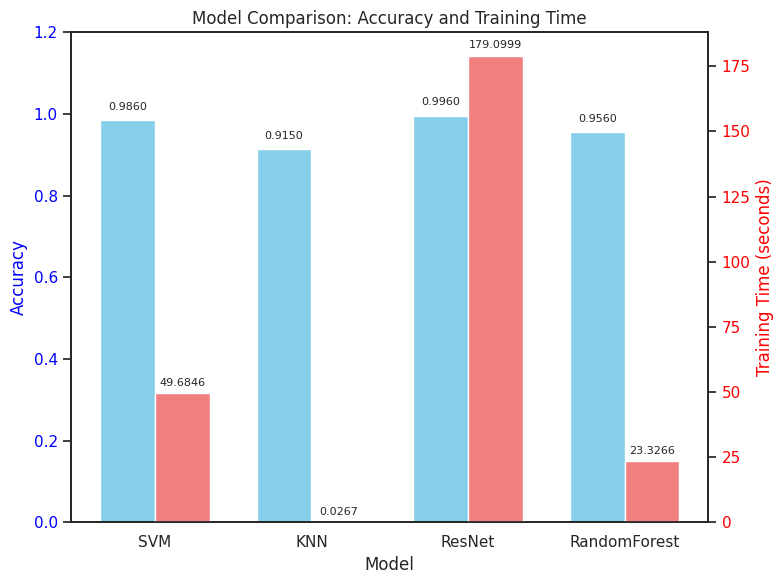

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# === Model names and actual values ===
models = ['SVM', 'KNN', 'ResNet', 'RandomForest']

accuracy = [98.6, 91.5, 99.6, 95.6]  # Accuracy percentages
train_time = [49.6846, 0.0267, 179.0999, 23.3266]  # Training time in seconds

x = np.arange(len(models))  # the label locations
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(8,6))

# Plot Accuracy (left y-axis)
bars1 = ax1.bar(x - width/2, [a/100 for a in accuracy], width, label='Accuracy', color='skyblue')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy', color='blue')
ax1.set_ylim(0, 1.2)  # Accuracy is scaled between 0 and 1
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.tick_params(axis='y', labelcolor='blue')

# Annotate accuracy values
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02,
             f"{accuracy[i]/100:.4f}", ha='center', va='bottom', fontsize=8)

# Plot Training Time (right y-axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, train_time, width, label='Training Time', color='lightcoral')
ax2.set_ylabel('Training Time (seconds)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Annotate training time values
for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height()+2,
             f"{train_time[i]:.4f}", ha='center', va='bottom', fontsize=8)

# Title
plt.title('Model Comparison: Accuracy and Training Time')

# Save figure
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/fruit_360/model_comparison.png', bbox_inches='tight')
plt.show()


# Model Validation


In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_features)
y = np.array(train_labels)

# Regular K-Fold (not stratified)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 5-fold CV
svm_scores = cross_val_score(model_svm, X_scaled, y, cv=kf, scoring='accuracy')
print("SVM 5-Fold Accuracies (Regular):", svm_scores)


SVM 5-Fold Accuracies (Regular): [0.99826087 1.         1.         0.99913043 0.99913043]


In [ ]:
# KNN model

# 5-fold CV
knn_scores = cross_val_score(model_knn, X_scaled, y, cv=kf, scoring='accuracy')
print("KNN 5-Fold Accuracies (Regular):", knn_scores)


KNN 5-Fold Accuracies (Regular): [0.9973913  1.         0.99826087 0.99913043 0.99478261]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 5-fold CV
rf_scores = cross_val_score(rf_model, X_scaled, y, cv=kf, scoring='accuracy')
print("Random Forest 5-Fold Accuracies (Regular):", rf_scores)


Random Forest 5-Fold Accuracies (Regular): [0.99652174 1.         1.         1.         1.        ]


In [ ]:
svm_scores = svm_scores.mean()
knn_scores = knn_scores.mean()
rf_scores = rf_scores.mean()
#resnet_scores = np.array(resnet_scores).mean()
svm_scores, knn_scores, rf_scores #, resnet_scores

(np.float64(0.9993043478260869),
 np.float64(0.9979130434782608),
 np.float64(0.9993043478260869))

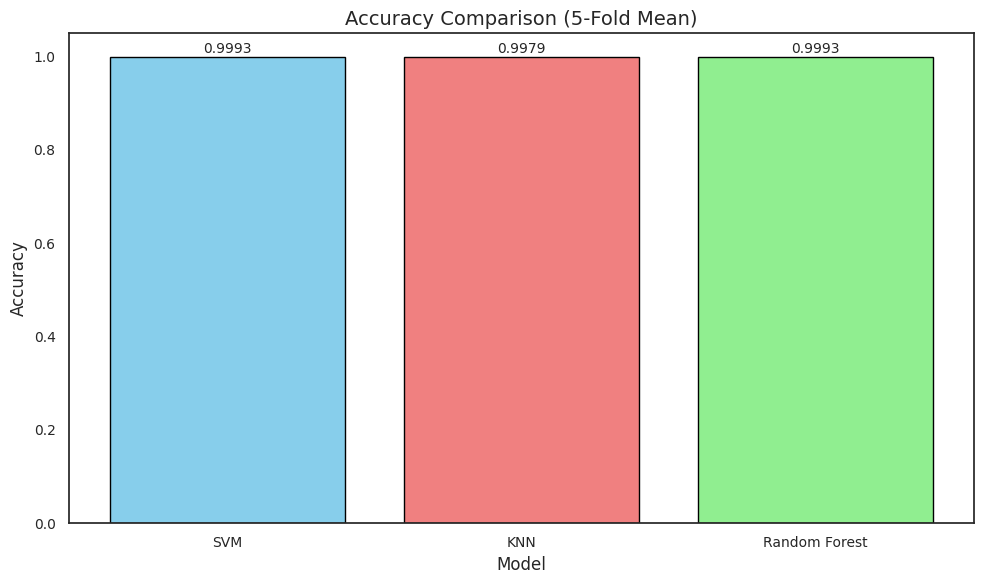

In [ ]:
model_class = ['SVM', 'KNN', 'Random Forest']
accuracy_scores = [svm_scores, knn_scores, rf_scores]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_class, accuracy_scores, color=['skyblue', 'lightcoral', 'lightgreen'], edgecolor='black')

plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.title('Accuracy Comparison (5-Fold Mean)', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Annotate each bar with the value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0,
             height + 0.002,  # small space above bar
             f'{height:.4f}',  # format to 4 decimal places
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/accuracy_comparison_cross_val.png', bbox_inches='tight')
plt.show()

# Prediction Demo

In [ ]:
start_time_rf = time.time()
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(train_features, train_labels)
rf_train_time = time.time() - start_time_rf

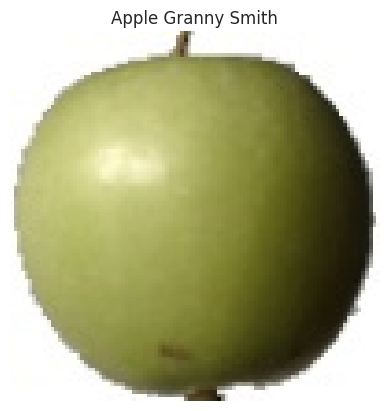

In [ ]:
# === Path to the test image ===
image_path = '/content/gdrive/MyDrive/fruit_360/granny_smith.jpg'

# === Load and display the input image ===
img = Image.open(image_path).convert('RGB')
plt.imshow(img)
plt.title("Apple Granny Smith")
plt.axis("off")
plt.show()

# === Preprocess the image for model ===
img_resized = img.resize((60, 60))  # Match training resolution
img_array = np.array(img_resized).flatten().reshape(1, -1)

In [ ]:
# === Predict using Random Forest ===
predicted_label = model_rf.predict(img_array)[0]
print(f" Predicted Apple Type: {predicted_label}")

 Predicted Apple Type: Apple Granny Smith 1
